In [1]:
import numpy as np

In [2]:
#test 2
import torch
E=np.array([[1,1,1,1],
[1,0,1,1],
[0,1,1,1],
[1,1,0,0]])

W=np.array([[3,3,4,5,3],
[6,0,7,8,8],
[0,9,10,11,3],
[12,13,0,0,1]])


Pin2=np.array([[0,0,1],
[1,0,0],
[0,1,0],
[1,0,0]])

Pin=np.array([[1,0,0],
[0,1,0],
[0,0,1],
[1,0,0]])

C=np.array([[0,19,5],
[7,0,3],
[1,11,0]])

Pout=np.array([[0,1,0],
[0,1,0],
[0,0,1],
[1,0,0]])

E=torch.from_numpy(E).float()
W=torch.from_numpy(W).float()
Pin=torch.from_numpy(Pin).float()
Pin2=torch.from_numpy(Pin2).float()
Pout=torch.from_numpy(Pout).float()
C=torch.from_numpy(C).float()


def compress(X,c=1):
    c=1-c
    if c==1:
        return X
    dout = X.shape[1]
    
    # Calculate L1 norm for each output channel
    if len(X.shape)==2:
        Xvalues = torch.abs(X)
    elif len(X.shape)==4:
        Xvalues = torch.sum(torch.abs(X), dim=(2, 3))

    print(Xvalues.shape)
    
    # Calculate how many channels to prune
    k = int(dout * c)

    x, i = torch.topk(Xvalues, k, dim=1)
    mask = torch.zeros_like(Xvalues,dtype=torch.int)
    src = torch.ones_like(i,dtype=torch.int)
    mask.scatter_(1, i, src)
    #print(Xvalues,x,i)
    #print(mask)
    if len(X.shape)==2:
        return mask*X
    else:
        #print(mask.shape,X.shape)
        #print(mask)
        mask=mask.unsqueeze(2)
        mask=mask.unsqueeze(3)
        mask=mask.repeat((1,1,X.shape[2],X.shape[3]))
        return mask*X
def fakekernel(t,k1=4,k2=4):
    t=t.unsqueeze(2)
    t=t.unsqueeze(3)
    t=t.repeat((1,1,k1,k2))
    return t
print(W.shape)
t=fakekernel(W)
print(t.shape)
print(compress(W,0))

torch.Size([4, 5])
torch.Size([4, 5, 4, 4])
tensor([[ 3.,  3.,  4.,  5.,  3.],
        [ 6.,  0.,  7.,  8.,  8.],
        [ 0.,  9., 10., 11.,  3.],
        [12., 13.,  0.,  0.,  1.]])


In [8]:
import numpy as np

def line_box_intersection(line_start, line_end, box_min, box_max):
    """
    Finds the intersection points of a line segment and an axis-aligned bounding box (AABB).

    Args:
        line_start (np.array): The start point of the line (e.g., np.array([x, y, z])).
        line_end (np.array): The end point of the line (e.g., np.array([x, y, z])).
        box_min (np.array): The minimum corner of the box (e.g., np.array([xmin, ymin, zmin])).
        box_max (np.array): The maximum corner of the box (e.g., np.array([xmax, ymax, zmax])).

    Returns:
        list: A list of intersection points (up to two points).
    """
    #thanks Google's AI
    line_dir = line_end - line_start
    # Pre-calculate inverse direction components to replace division with multiplication (faster)
    # Handle cases where a component is zero
    inv_dir = np.array([1/line_dir[i] if line_dir[i] != 0 else np.inf for i in range(len(line_dir))])

    t_min = -np.inf
    t_max = np.inf
    
    intersection_points = []

    for i in range(len(line_start)): # Iterate over x, y, z dimensions
        t1 = (box_min[i] - line_start[i]) * inv_dir[i]
        t2 = (box_max[i] - line_start[i]) * inv_dir[i]

        # Ensure t1 is the smaller intersection parameter
        if t1 > t2:
            t1, t2 = t2, t1

        # Update the overall t_min and t_max for the intersection interval
        t_min = max(t_min, t1)
        t_max = min(t_max, t2)

        # If t_min becomes greater than t_max, the line does not intersect the box
        if t_min > t_max:
            return []

    # The line intersects the box. The intersection occurs between t_min and t_max.
    # The actual points of entry and exit within the original line segment range [0, 1] are determined here.

    # Clamp t_min and t_max to the line segment range [0, 1] if you're working with a segment
    # If using an infinite line, skip this clamping step.
    t_start = max(0, t_min)
    t_end = min(1, t_max)

    if t_start <= t_end:
        # Calculate intersection points
        if t_start >= 0 and t_start <= 1:
            points = line_start + t_start * line_dir
            intersection_points.append(points)
        if t_end >= 0 and t_end <= 1 and t_end != t_start: # Avoid adding the same point twice
            points = line_start + t_end * line_dir
            intersection_points.append(points)
            
    return intersection_points

# --- Example Usage (3D) ---
line_start = np.array([-1.0, 0.5, 0.5])
line_end = np.array([2.0, 0.5, 0.5])
box_min = np.array([0.0, 0.0, 0.0])
box_max = np.array([1.0, 1.0, 1.0])

intersections = line_box_intersection(line_start, line_end, box_min, box_max)

if intersections:
    print(f"Intersection points: {intersections}")
else:
    print("No intersection points found.")

# --- Example Usage (2D) ---
# For 2D, the logic remains the same, just use 2-element arrays
line_start_2d = np.array([0.5, 0.0])
line_end_2d = np.array([1.5, 1])
box_min_2d = np.array([0.0, 0.0])
box_max_2d = np.array([1.0, 1.0])

intersections_2d = line_box_intersection(line_start_2d, line_end_2d, box_min_2d, box_max_2d)

if intersections_2d:
    print(f"2D Intersection points: {intersections_2d}")
else:
    print("No 2D intersection points found.")


Intersection points: [array([0. , 0.5, 0.5]), array([1. , 0.5, 0.5])]
2D Intersection points: [array([0.5, 0. ]), array([1. , 0.5])]


In [9]:
def split_line_segment(start_point, end_point, segments):
    """
    Splits a line segment into a list of equally spaced points (including start and end).

    Args:
        start_point (tuple): (x1, y1)
        end_point (tuple): (x2, y2)
        segments (int): The number of line segments (points will be segments + 1).

    Returns:
        list: A list of points as tuples [(x1, y1), ..., (x2, y2)]
    """
    #thanks Google's AI
    if segments < 1:
        raise ValueError("Segments must be at least 1")

    x1, y1 = start_point
    x2, y2 = end_point

    x_delta = (x2 - x1) / float(segments)
    y_delta = (y2 - y1) / float(segments)

    points = []
    for i in range(segments + 1):
        points.append((x1 + i * x_delta, y1 + i * y_delta))
    
    return points

# Example Usage
start = (-10, 20)
end = (20, 75)
num_segments = 5 # This will produce 6 points (5 intermediate + start/end)

result_points = split_line_segment(start, end, num_segments)
print(result_points)


[(-10.0, 20.0), (-4.0, 31.0), (2.0, 42.0), (8.0, 53.0), (14.0, 64.0), (20.0, 75.0)]


In [17]:
import numpy as np

def split_line_nd(start_point, end_point, num_points):
    """
    Generates num_points equally spaced along a line segment between 
    start_point and end_point in N dimensions.

    Args:
        start_point (iterable): The starting point (e.g., [x1, y1, z1])
        end_point (iterable): The ending point (e.g., [x2, y2, z2])
        num_points (int): The total number of points to generate (must be >= 2).

    Returns:
        np.ndarray: An array of shape (num_points, N) containing the points.
    """
    if num_points < 2:
        return np.array([start_point, end_point])

    # Convert to numpy arrays for easier calculation
    p1 = np.array(start_point)
    p2 = np.array(end_point)
    
    # Generate the interpolation factors (0 to 1)
    # The number of steps is num_points - 1
    t = np.linspace(0, 1, num_points)

    # Linear interpolation formula: P(t) = P1 + t * (P2 - P1)
    # The result will be an array of points
    points = p1 + t[:, np.newaxis] * (p2 - p1)
    
    return points

# Example 1: 2D Points
start_2d = [0, 0]
end_2d = [10, 20]
points_2d = split_line_nd(start_2d, end_2d, 5)
print("2D Points:")
print(points_2d)

print("-" * 20)

# Example 2: 4D Points
start_4d = [1, 2, 3, 4]
end_4d = [10, 20, 30, 40]
points_4d = split_line_nd(start_4d, end_4d, 4)
print("4D Points:")
print(points_4d)


2D Points:
[[ 0.   0. ]
 [ 2.5  5. ]
 [ 5.  10. ]
 [ 7.5 15. ]
 [10.  20. ]]
--------------------
4D Points:
[[ 1.  2.  3.  4.]
 [ 4.  8. 12. 16.]
 [ 7. 14. 21. 28.]
 [10. 20. 30. 40.]]


In [30]:
def getcpoints(x0,u,num_segments=5):
    x1=x0+u
    box_min = np.zeros_like(x0)
    box_max = np.ones_like(x0)
    start,end = line_box_intersection(x0, x1, box_min, box_max)
    #print(start,end)
    result_points = split_line_nd(start, end, num_segments)
    return(result_points)

line_start_2d = np.array([0.5, 0.0,0,0])
line_dir = np.array([1, 1,0.5,0.5])
print(getcpoints(line_start_2d,line_dir,8))


[[0.5        0.         0.         0.        ]
 [0.57142857 0.07142857 0.03571429 0.03571429]
 [0.64285714 0.14285714 0.07142857 0.07142857]
 [0.71428571 0.21428571 0.10714286 0.10714286]
 [0.78571429 0.28571429 0.14285714 0.14285714]
 [0.85714286 0.35714286 0.17857143 0.17857143]
 [0.92857143 0.42857143 0.21428571 0.21428571]
 [1.         0.5        0.25       0.25      ]]


In [33]:
#!!!!!

In [31]:
line_start_2d = np.array([0, 0.0,0,0])
line_dir = np.array([1, 0,0,0])
print(getcpoints(line_start_2d,line_dir,6))

[[0.  0.  0.  0. ]
 [0.2 0.  0.  0. ]
 [0.4 0.  0.  0. ]
 [0.6 0.  0.  0. ]
 [0.8 0.  0.  0. ]
 [1.  0.  0.  0. ]]


/tmp/ipykernel_3417441/3542054482.py:28: RuntimeWarning: invalid value encountered in scalar multiply
  t1 = (box_min[i] - line_start[i]) * inv_dir[i]


In [37]:
line_start_2d = np.array([0, 0.0,0,0])
line_dir = np.array([1, 1,1,1])
print(getcpoints(line_start_2d,line_dir,6))

[[0.  0.  0.  0. ]
 [0.2 0.2 0.2 0.2]
 [0.4 0.4 0.4 0.4]
 [0.6 0.6 0.6 0.6]
 [0.8 0.8 0.8 0.8]
 [1.  1.  1.  1. ]]


In [35]:
line_start_2d = np.array([0, 0.0,0,0])
line_dir = np.array([0, 1,1,0])
print(getcpoints(line_start_2d,line_dir,6))

[[0.  0.  0.  0. ]
 [0.  0.2 0.2 0. ]
 [0.  0.4 0.4 0. ]
 [0.  0.6 0.6 0. ]
 [0.  0.8 0.8 0. ]
 [0.  1.  1.  0. ]]


/tmp/ipykernel_3417441/3542054482.py:28: RuntimeWarning: invalid value encountered in scalar multiply
  t1 = (box_min[i] - line_start[i]) * inv_dir[i]


In [29]:
line_start_2d = np.array([0, 0.0,0,0])
line_dir = np.array([0.25, 0.5,0.75,1])
print(getcpoints(line_start_2d,line_dir,6))

[0. 0. 0. 0.] [0.25 0.5  0.75 1.  ]
[[0.   0.   0.   0.  ]
 [0.05 0.1  0.15 0.2 ]
 [0.1  0.2  0.3  0.4 ]
 [0.15 0.3  0.45 0.6 ]
 [0.2  0.4  0.6  0.8 ]
 [0.25 0.5  0.75 1.  ]]


In [40]:
line_start_2d = np.array([0, 0.0,0,0])
line_dir = np.array([0, 0.3,1,1])
print(getcpoints(line_start_2d,line_dir,6))

[[0.   0.   0.   0.  ]
 [0.   0.06 0.2  0.2 ]
 [0.   0.12 0.4  0.4 ]
 [0.   0.18 0.6  0.6 ]
 [0.   0.24 0.8  0.8 ]
 [0.   0.3  1.   1.  ]]


/tmp/ipykernel_3417441/3542054482.py:28: RuntimeWarning: invalid value encountered in scalar multiply
  t1 = (box_min[i] - line_start[i]) * inv_dir[i]


In [34]:
#!!!!!

In [ ]:
#test 2
import torch
E=np.array([[1,1,1,1],
[1,0,1,1],
[0,1,1,1],
[1,1,0,0]])

W=np.array([[3,3,4,5],
[6,0,7,8],
[0,9,10,11],
[12,13,0,0]])


Pin2=np.array([[0,0,1],
[1,0,0],
[0,1,0],
[1,0,0]])

Pin=np.array([[1,0,0],
[0,1,0],
[0,0,1],
[1,0,0]])

C=np.array([[0,19,5],
[7,0,3],
[1,11,0]])

Pout=np.array([[0,1,0],
[0,1,0],
[0,0,1],
[1,0,0]])

E=torch.from_numpy(E).float()
W=torch.from_numpy(W).float()
Pin=torch.from_numpy(Pin).float()
Pin2=torch.from_numpy(Pin2).float()
Pout=torch.from_numpy(Pout).float()
C=torch.from_numpy(C).float()


print(W)
parents=[1,2]
layer_name=3
P={}
P[1]=Pin
P[2]=Pin2
P[3]=Pout
comm_costs=0
for parent in parents:
    #print(ra.P[parent].shape)
    #print(ra.C.shape)
    #print(torch.transpose(ra.P[layer_name],0,1).shape )
    #print(ADMM.P[parent].device,C.device,ADMM.P[layer_name].device)
    cc=P[parent] @ C @ torch.transpose(P[layer_name],0,1)   
    print(parent,cc)
    comm_costs+=cc
#print(comm_costs.shape)
print( torch.transpose(comm_costs,0,1))
parents = [self.adoptparents(P) for P in self.partition[name].get('parents', [])]

tensor([[ 3.,  3.,  4.,  5.],
        [ 6.,  0.,  7.,  8.],
        [ 0.,  9., 10., 11.],
        [12., 13.,  0.,  0.]])
1 tensor([[19., 19.,  5.,  0.],
        [ 0.,  0.,  3.,  7.],
        [11., 11.,  0.,  1.],
        [19., 19.,  5.,  0.]])
2 tensor([[11., 11.,  0.,  1.],
        [19., 19.,  5.,  0.],
        [ 0.,  0.,  3.,  7.],
        [19., 19.,  5.,  0.]])
tensor([[30., 19., 11., 38.],
        [30., 19., 11., 38.],
        [ 5.,  8.,  3., 10.],
        [ 1.,  7.,  8.,  0.]])


In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
x=np.array([2])
w=np.array([3])
y=x**2
y+=1
x

array([2])

In [ ]:
d1 = {1: 1, 2: 2}
d2 = {4: 'ha!', 3: 3}
d1['d2'] = d2
d1

{1: 1, 2: 2, 'd2': {4: 'ha!', 3: 3}}

In [ ]:
import torch
t=torch.tensor([[2,2,4],[1,1,9]])
t=t.unsqueeze(2)
t=t.unsqueeze(3)
#t=t.repeat((1,1,3,3))
t.shape

torch.Size([2, 3, 1, 1])

In [ ]:
t=torch.tensor([[1,0,0],[0,1,0],[0,0,1],[0,1,0],[0,0,1],[0,0,1],[1,0,0],[0,1,0],[1,0,0],[0,1,0],[0,0,1],[0,1,0],[0,0,1],[0,0,1],[1,0,0],[0,1,0]])

In [ ]:
t

tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0]])

In [ ]:
x=t[:,0]==1
i=x.nonzero().squeeze().tolist()
i

[0, 6, 8, 14]

In [ ]:
m=t.shape[1]
L=[]
i=t.nonzero()
for j in range(m):
    l=i[i[:,1]==j][:,0].tolist()
    print(l)
    L.append(l)
print(L)

[0, 6, 8, 14]
[1, 3, 7, 9, 11, 15]
[2, 4, 5, 10, 12, 13]
[[0, 6, 8, 14], [1, 3, 7, 9, 11, 15], [2, 4, 5, 10, 12, 13]]


In [ ]:
from numpy import linalg as LA
E=np.array([[1,1,1,1],
[1,0,1,1],
[0,1,1,1],
[1,1,0,0]])

W=np.array([[3,3,4,5],
[6,0,7,8],
[0,9,10,11],
[12,13,0,0]])


Pin2=np.array([[0,0,1],
[1,0,0],
[0,1,0],
[1,0,0]])

Pin=np.array([[1,0,0],
[0,1,0],
[0,0,1],
[1,0,0]])

C=np.array([[0,19,5],
[7,0,3],
[1,11,0]])

Pout=np.array([[0,1,0],
[0,1,0],
[0,0,1],
[1,0,0]])

#all parents
P3=Pin+Pin2
P3[P3!=0]=1
print(P3)

pr=1/2


E=W**2
needs=E@P3
needs=np.sqrt((needs))
print(needs)
row_l2_norm = LA.norm(W[:,[0,1,3]], axis=1)
print(row_l2_norm)

total=needs.shape[0]*needs.shape[1]
keep=(1-pr)*total
aligned_keep=needs.shape[0]
misaligned_keep=keep-aligned_keep
misaligned_total=total-aligned_keep
apr=misaligned_keep/total
print(total,keep,aligned_keep,misaligned_keep,misaligned_total,apr)

c2=1-Pout
print("c2", c2)
res1=needs*c2
print("res1", res1)
t=torch.quantile(torch.from_numpy(res1), 1-apr).item()
print(t)
res1[res1>t]=1
res1[res1!=1]=0
print(res1)
res1=res1+Pout
print(res1)
mask=res1@np.transpose(P3)
mask[mask!=0]=1
print(mask)






[[1 0 1]
 [1 1 0]
 [0 1 1]
 [1 0 0]]
[[ 6.55743852  5.          5.        ]
 [10.          7.          9.21954446]
 [14.2126704  13.45362405 10.        ]
 [17.69180601 13.         12.        ]]
[ 6.55743852 10.         14.2126704  17.69180601]
12 6.0 4 2.0 8 0.16666666666666666
c2 [[1 0 1]
 [1 0 1]
 [1 1 0]
 [0 1 1]]
res1 [[ 6.55743852  0.          5.        ]
 [10.          0.          9.21954446]
 [14.2126704  13.45362405  0.        ]
 [ 0.         13.         12.        ]]
13.07560400784562
[[0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 0.]
 [0. 0. 0.]]
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 1. 1.]
 [1. 0. 0.]]
[[0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [1. 1. 1. 1.]
 [1. 1. 0. 1.]]


In [ ]:
#test
E=np.array([[1,1,1,1],
[1,0,1,1],
[0,1,1,1],
[1,1,0,0]])

W=np.array([[3,3,4,5],
[6,0,7,8],
[0,9,10,11],
[12,13,0,0]])


Pin2=np.array([[0,0,1],
[1,0,0],
[0,1,0],
[1,0,0]])

Pin=np.array([[1,0,0],
[0,1,0],
[0,0,1],
[1,0,0]])

C=np.array([[0,19,5],
[7,0,3],
[1,11,0]])

Pout=np.array([[0,1,0],
[0,1,0],
[0,0,1],
[1,0,0]])

E=torch.from_numpy(E).float()
W=torch.from_numpy(W).float()
Pin=torch.from_numpy(Pin).float()
Pin2=torch.from_numpy(Pin2).float()
Pout=torch.from_numpy(Pout).float()
C=torch.from_numpy(C).float()

P=Pin+Pin2
P[P!=0]=1

prune_ratio=0.5
print(P)
print(W)
E=W**2

needs=torch.sqrt(E@P)
#W[W!=0]=1
needs=W@P
print(needs)


#adjust semantics pr is ratio of pruned to total
total=needs.shape[0]*needs.shape[1]
aligned_keep=needs.shape[0]
misaligned_total=total-aligned_keep

misaligned_keep=(1-prune_ratio)*misaligned_total            
apr=misaligned_keep/total

c2=1-Pout
res1=needs*c2
print(Pout)
print(res1)

t=torch.quantile(res1, 1-apr) 
res1[res1>t]=1
res1[res1!=1]=0
res1=res1+Pout
print(res1)

mask=res1@torch.transpose(P,0,1)
mask[mask!=0]=1
print(mask)


res2=1-res1
print(res2)

mask2=res2@torch.transpose(P,0,1)
mask2[mask2!=0]=1
mask2=1-mask2
print(mask2)


tensor([[1., 0., 1.],
        [1., 1., 0.],
        [0., 1., 1.],
        [1., 0., 0.]])
tensor([[ 3.,  3.,  4.,  5.],
        [ 6.,  0.,  7.,  8.],
        [ 0.,  9., 10., 11.],
        [12., 13.,  0.,  0.]])
tensor([[11.,  7.,  7.],
        [14.,  7., 13.],
        [20., 19., 10.],
        [25., 13., 12.]])
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.]])
tensor([[11.,  0.,  7.],
        [14.,  0., 13.],
        [20., 19.,  0.],
        [ 0., 13., 12.]])
tensor([[0., 1., 0.],
        [1., 1., 0.],
        [1., 1., 1.],
        [1., 0., 0.]])
tensor([[0., 1., 1., 0.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 0., 1.]])
tensor([[1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 0.],
        [0., 1., 1.]])
tensor([[0., 0., 0., 0.],
        [0., 1., 0., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 1.]])


In [ ]:
#test 2
E=np.array([[1,1,1,1],
[1,0,1,1],
[0,1,1,1],
[1,1,0,0]])

W=np.array([[3,3,4,5],
[6,0,7,8],
[0,9,10,11],
[12,13,0,0]])


Pin2=np.array([[0,0,1],
[1,0,0],
[0,1,0],
[1,0,0]])

Pin=np.array([[1,0,0],
[0,1,0],
[0,0,1],
[1,0,0]])

C=np.array([[0,19,5],
[7,0,3],
[1,11,0]])

Pout=np.array([[0,1,0],
[0,1,0],
[0,0,1],
[1,0,0]])

E=torch.from_numpy(E).float()
W=torch.from_numpy(W).float()
Pin=torch.from_numpy(Pin).float()
Pin2=torch.from_numpy(Pin2).float()
Pout=torch.from_numpy(Pout).float()
C=torch.from_numpy(C).float()

P=Pin+Pin2
P[P!=0]=1

prune_ratio=0.5
print(P)
print(W)
E=W**2

needs=torch.sqrt(E@P)
#W[W!=0]=1
needs=W@P
print(needs)


#adjust semantics pr is ratio of pruned to total
total=needs.shape[0]*needs.shape[1]
aligned_keep=needs.shape[0]
misaligned_total=total-aligned_keep

misaligned_keep=(1-prune_ratio)*misaligned_total            
apr=misaligned_keep/total

c2=1-Pout
res1=needs*c2
print(Pout)
print(res1)

t=torch.quantile(res1, 1-apr) 
res1[res1>t]=1
res1[res1!=1]=0
res1=res1+Pout
print(res1)

mask=res1@torch.transpose(P,0,1)
mask[mask!=0]=1
print(mask)


res2=1-res1
print(res2)

mask2=res2@torch.transpose(P,0,1)
mask2[mask2!=0]=1
mask2=1-mask2
print(mask2)


print("!!!!!!!")
W2=W*mask2
zeros=0
total=0
zerosp=0
totalp=0
E=W2
E[E!=0]=1
print(E)
(n1,n2)=E.shape
total=n1*n2
zeros=total-E.sum()
print(zeros)
print("kernels",total,zeros,zeros/total)
#lin alg
needs=E@P
needs[needs!=0]=1
print(needs)
(n,m)=needs.shape
totalp=n*m
zerosp=totalp-needs.sum()
print("rows",totalp,zerosp,zerosp/totalp)

c2=1-Pout
offneeds=needs*c2
offtotalp=totalp-n
offzerosp=offtotalp-offneeds.sum()
print("off rows",offtotalp,offzerosp,offzerosp/offtotalp)
print(prune_ratio)


tensor([[1., 0., 1.],
        [1., 1., 0.],
        [0., 1., 1.],
        [1., 0., 0.]])
tensor([[ 3.,  3.,  4.,  5.],
        [ 6.,  0.,  7.,  8.],
        [ 0.,  9., 10., 11.],
        [12., 13.,  0.,  0.]])
tensor([[11.,  7.,  7.],
        [14.,  7., 13.],
        [20., 19., 10.],
        [25., 13., 12.]])
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.]])
tensor([[11.,  0.,  7.],
        [14.,  0., 13.],
        [20., 19.,  0.],
        [ 0., 13., 12.]])
tensor([[0., 1., 0.],
        [1., 1., 0.],
        [1., 1., 1.],
        [1., 0., 0.]])
tensor([[0., 1., 1., 0.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 0., 1.]])
tensor([[1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 0.],
        [0., 1., 1.]])
tensor([[0., 0., 0., 0.],
        [0., 1., 0., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 1.]])
!!!!!!!
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 1., 1.],
        [0., 0., 0., 0.]]

In [ ]:
#test 2
E=np.array([[1,1,1,1],
[1,0,1,1],
[0,1,1,1],
[1,1,0,0]])

W=np.array([[3,3,4,5],
[6,0,7,8],
[0,9,10,11],
[12,13,0,0]])


Pin2=np.array([[0,0,1],
[1,0,0],
[0,1,0],
[1,0,0]])

Pin=np.array([[1,0,0],
[0,1,0],
[0,0,1],
[1,0,0]])

C=np.array([[0,19,5],
[7,0,3],
[1,11,0]])

Pout=np.array([[0,1,0],
[0,1,0],
[0,0,1],
[1,0,0]])

E=torch.from_numpy(E).float()
W=torch.from_numpy(W).float()
Pin=torch.from_numpy(Pin).float()
Pin2=torch.from_numpy(Pin2).float()
Pout=torch.from_numpy(Pout).float()
C=torch.from_numpy(C).float()


print(W)
parents=[1,2]
layer_name=3
P={}
P[1]=Pin
P[2]=Pin2
P[3]=Pout
comm_costs=0
for parent in parents:
    #print(ra.P[parent].shape)
    #print(ra.C.shape)
    #print(torch.transpose(ra.P[layer_name],0,1).shape )
    #print(ADMM.P[parent].device,C.device,ADMM.P[layer_name].device)
    cc=P[parent] @ C @ torch.transpose(P[layer_name],0,1)   
    print(parent,cc)
    comm_costs+=cc
#print(comm_costs.shape)
print( torch.transpose(comm_costs,0,1))

tensor([[ 3.,  3.,  4.,  5.],
        [ 6.,  0.,  7.,  8.],
        [ 0.,  9., 10., 11.],
        [12., 13.,  0.,  0.]])
1 tensor([[19., 19.,  5.,  0.],
        [ 0.,  0.,  3.,  7.],
        [11., 11.,  0.,  1.],
        [19., 19.,  5.,  0.]])
2 tensor([[11., 11.,  0.,  1.],
        [19., 19.,  5.,  0.],
        [ 0.,  0.,  3.,  7.],
        [19., 19.,  5.,  0.]])
tensor([[30., 19., 11., 38.],
        [30., 19., 11., 38.],
        [ 5.,  8.,  3., 10.],
        [ 1.,  7.,  8.,  0.]])


In [ ]:
E=np.array([[1,1,1,1],
[1,0,1,1],
[0,1,1,1],
[1,1,0,0]])

Pin=np.array([[1,0],
[0,1],
[1,0],
[1,0]])

C=np.array([[0,19],
[7,0]])

Pout=np.array([[0,1],
[0,1],
[1,0],
[1,0]])


needs=E@Pin
print(needs)
needs[needs!=0]=1
a=1
#needs=torch.tanh(torch.from_numpy(a*needs)).numpy()
#needs=pnormalize(needs)
print(needs)
costs=Pout@C
print(costs)

res2=needs*costs
print(np.sum(res2))


[[3 1]
 [3 0]
 [2 1]
 [1 1]]
[[1 1]
 [1 0]
 [1 1]
 [1 1]]
[[ 7  0]
 [ 7  0]
 [ 0 19]
 [ 0 19]]
52


In [ ]:
E=np.array([[1,1,1,1],
[1,0,1,1],
[0,1,1,1],
[1,1,0,0]])

Pin=np.array([[1,0],
[0,1],
[1,0],
[1,0]])

C=np.array([[0,19],
[7,0]])

Pout=np.array([[0,1],
[0,1],
[1,0],
[1,0]])


needs=E@Pin
print(needs)
needs[needs!=0]=1
a=1
#needs=torch.tanh(torch.from_numpy(a*needs)).numpy()
#needs=pnormalize(needs)
print(needs)
costs=C
print(costs)

res2=needs@costs
print(res2)


[[3 1]
 [3 0]
 [2 1]
 [1 1]]
[[1 1]
 [1 0]
 [1 1]
 [1 1]]
[[ 0 19]
 [ 7  0]]
[[ 7 19]
 [ 0 19]
 [ 7 19]
 [ 7 19]]


In [ ]:
import matplotlib.pyplot as plt
def ppp(f):
    # Create an array of x values
    x = np.linspace(0, 10, 1000)
    a=20
    # Calculate the PDF for each x value
    pdf = torch.tanh(torch.from_numpy(a*x)).numpy()

    # Plot the PDF
    plt.plot(x, pdf)
    plt.show()

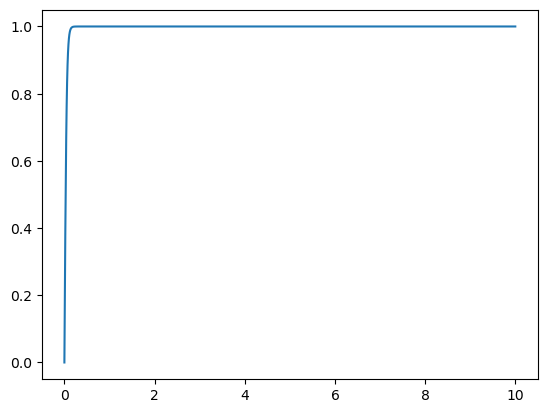

In [ ]:
f=torch.tanh
ppp(f)

In [ ]:
def softmax(x):
    """
    Computes the softmax function for a given numpy array.

    Args:
        x (numpy.ndarray): Input array.

    Returns:
        numpy.ndarray: Softmax output.
    """
    e_x = np.exp((x - np.max(x))) # Subtracting np.max(x) for numerical stability
    return e_x / e_x.sum(axis=0)

In [ ]:
def pnormalize(x,p=2):
    """
    Computes the softmax function for a given numpy array.

    Args:
        x (numpy.ndarray): Input array.

    Returns:
        numpy.ndarray: Softmax output.
    """
    e_x = x**p # Subtracting np.max(x) for numerical stability
    return e_x #/ e_x.sum(axis=0)

In [ ]:
E=np.array([[1,1,1,1],
[1,0,1,1],
[0,1,1,1],
[1,1,0,0]])

Pin=np.array([[0.8,0.2],
[0.2,0.8],
[0.8,0.2],
[0.8,0.2]])

C=np.array([[0,19],
[7,0]])

Pout=np.array([[0.2,0.8],
[0.2,0.8],
[0.8,0.2],
[0.8,0.2]])


needs=E@Pin
print(needs)
#needs[needs!=0]=1
needs=pnormalize(needs)

print(needs)
costs=Pout@C
print(costs)

res2=needs*costs
print(np.sum(res2,axis=1))


[[2.6 1.4]
 [2.4 0.6]
 [1.8 1.2]
 [1.  1. ]]
[[6.76 1.96]
 [5.76 0.36]
 [3.24 1.44]
 [1.   1.  ]]
[[ 5.6  3.8]
 [ 5.6  3.8]
 [ 1.4 15.2]
 [ 1.4 15.2]]
[45.304 33.624 26.424 16.6  ]


## Create topolgies

In [ ]:
import numpy as np
import topologies
import networkx as nx
import yaml
import json

In [ ]:
def create_maps_from_E(N,E):
    #maps=np.full((N,N),10e10) #  99
    maps=np.full((N,N),99) #  99
    for i in range(N):
        maps[i,i]=0
    for (i,j,v) in E:
        maps[i,j]=v
        maps[j,i]=v
    return maps


In [ ]:
def create_yaml_file(N, model_type, maps,costs=False):
    # valid: resnet18, resnet101
    if model_type == 'resnet18':
        layers_num = 20
        layers_str = "[inputs, conv1.weight, layer1.0.conv1.weight, layer1.0.conv2.weight, layer1.1.conv1.weight, layer1.1.conv2.weight, layer2.0.conv1.weight, layer2.0.conv2.weight, layer2.0.shortcut.0.weight, layer2.1.conv1.weight, layer2.1.conv2.weight, layer3.0.conv1.weight, layer3.0.conv2.weight, layer3.0.shortcut.0.weight, layer3.1.conv1.weight, layer3.1.conv2.weight, layer4.0.conv1.weight, layer4.0.conv2.weight, layer4.0.shortcut.0.weight, layer4.1.conv1.weight, layer4.1.conv2.weight]"

    if model_type == 'resnet101':
        layers_num = 70
        layers_str =  "[inputs, conv1.weight, layer1.0.conv1.weight, layer1.0.conv2.weight, layer1.1.conv1.weight, \
            layer1.1.conv2.weight, layer1.2.conv1.weight, layer1.2.conv2.weight, layer2.0.conv1.weight, \
            layer2.0.conv2.weight, layer2.0.shortcut.0.weight, layer2.1.conv1.weight, layer2.1.conv2.weight, \
            layer2.2.conv1.weight, layer2.2.conv2.weight, layer2.3.conv1.weight, layer2.3.conv2.weight, \
            layer3.0.conv1.weight, layer3.0.conv2.weight, layer3.0.shortcut.0.weight, layer3.1.conv1.weight, \
            layer3.1.conv2.weight, layer3.2.conv1.weight, layer3.2.conv2.weight, layer3.3.conv1.weight, \
            layer3.3.conv2.weight, layer3.4.conv1.weight, layer3.4.conv2.weight, layer3.5.conv1.weight, \
            layer3.5.conv2.weight, layer3.6.conv1.weight, layer3.6.conv2.weight, layer3.7.conv1.weight, \
            layer3.7.conv2.weight, layer3.8.conv1.weight, layer3.8.conv2.weight, layer3.9.conv1.weight, \
            layer3.9.conv2.weight, layer3.10.conv1.weight, layer3.10.conv2.weight, layer3.11.conv1.weight, \
            layer3.11.conv2.weight, layer3.12.conv1.weight, layer3.12.conv2.weight, layer3.13.conv1.weight, \
            layer3.13.conv2.weight, layer3.14.conv1.weight, layer3.14.conv2.weight, layer3.15.conv1.weight, \
            layer3.15.conv2.weight, layer3.16.conv1.weight, layer3.16.conv2.weight, layer3.17.conv1.weight, \
            layer3.17.conv2.weight, layer3.18.conv1.weight, layer3.18.conv2.weight, layer3.19.conv1.weight, \
            layer3.19.conv2.weight, layer3.20.conv1.weight, layer3.20.conv2.weight, layer3.21.conv1.weight, \
            layer3.21.conv2.weight, layer3.22.conv1.weight, layer3.22.conv2.weight, layer4.0.conv1.weight, \
            layer4.0.conv2.weight, layer4.0.shortcut.0.weight, layer4.1.conv1.weight, layer4.1.conv2.weight, \
            layer4.2.conv1.weight, layer4.2.conv2.weight]"  

    yaml_dict = {}
    yaml_dict['bn_partitions'] = [N] * 9
    initial_budget = [1] * N
    yaml_dict['budgets'] = np.tile(initial_budget, (layers_num, 1)).tolist()
    yaml_dict['initial_budget'] = initial_budget
    yaml_dict['input_partition'] = initial_budget
    yaml_dict['layers'] = layers_str
    yaml_dict['maps'] = maps.tolist() #np.array2string(maps, threshold=10000)
    yaml_dict['num'] = N
    yaml_str = json.dumps(yaml_dict)

    yaml_str = yaml_str.replace("\"", "")
    yaml_str = yaml_str.replace(", budgets: ", "\nbudgets: ")
    yaml_str = yaml_str.replace(", initial_budget: ", "\ninitial_budget: ")
    yaml_str = yaml_str.replace(", input_partition: ", "\ninput_partition: ")
    yaml_str = yaml_str.replace(", layers: ", "\nlayers: ")
    yaml_str = yaml_str.replace(", maps: ", "\nmaps: ")
    yaml_str = yaml_str.replace(", num: ", "\nnum: ")
    yaml_str = yaml_str.replace("{", "")
    yaml_str = yaml_str.replace("}", "")
    '''
    yaml_str = yaml_str.replace(", '", "\n'")
    yaml_str = yaml_str.replace("{", "")
    yaml_str = yaml_str.replace("}", "")
    yaml_str = yaml_str.replace("array(", "")
    yaml_str = yaml_str.replace("]])", "]]")
    yaml_str = yaml_str.replace("],", "]\n")
    '''
    yaml_str = yaml_str.replace("layer1.1.conv1.weight,", "layer1.1.conv1.weight,\n")
    yaml_str = yaml_str.replace("layer2.0.shortcut.0.weight,", "layer2.0.shortcut.0.weight,\n")
    yaml_str = yaml_str.replace("layer3.0.conv2.weight,", "layer3.0.conv2.weight,\n")
    yaml_str = yaml_str.replace("layer4.0.conv1.weight,", "layer4.0.conv1.weight,\n")

    yaml_str = yaml_str.replace("layer1.1.conv2.weight,", "        layer1.1.conv2.weight,")
    yaml_str = yaml_str.replace("layer2.1.conv1.weight,", "        layer2.1.conv1.weight,")
    yaml_str = yaml_str.replace("layer3.0.shortcut.0.weight,", "        layer3.0.shortcut.0.weight,")
    yaml_str = yaml_str.replace("layer4.0.conv2.weight", "        layer4.0.conv2.weight")
    '''
    yaml_str = yaml_str.replace("\"", "")
    yaml_str = yaml_str.replace(", maps: ", "\nmaps: ")
    '''
    if costs:
        yaml_filename = "./config/" + model_type + "-np" + str(N) + "-" + experiment_name + "_cost.yaml"
    else:
        yaml_filename = "./config/" + model_type + "-np" + str(N) + "-" + experiment_name + ".yaml"
    print(yaml_filename)
    with open(yaml_filename, 'w') as file:
        file.write(yaml_str)
    print(yaml_str)



In [ ]:
costs=False
model_type = 'resnet101' # valid: resnet18, resnet101
experiment_name = 'Dtelekom' # valid: GEANT, Dtelekom, Abilene, ServiceNetwork, WattsStrogatz, BarabasiAlbert

if experiment_name == 'GEANT':
    graph = topologies.GEANT()
if experiment_name == 'Dtelekom':
    graph = topologies.Dtelekom()
if experiment_name == 'Abilene':
    graph = topologies.Abilene()
if experiment_name == 'ServiceNetwork':
    graph = topologies.ServiceNetwork()
if experiment_name == 'WattsStrogatz':
    graph = nx.watts_strogatz_graph(n=10, k=4, p=0.5)
if experiment_name == 'BarabasiAlbert':
    graph = nx.barabasi_albert_graph(n=10, m=4)
if experiment_name == 'Uniform':
    graph = nx.complete_graph(n=8)

In [ ]:
print(graph.number_of_nodes())
N = graph.number_of_nodes()
print(graph.number_of_edges())
print(list(graph.nodes))
print(list(graph.edges))


68
273
['Node00', 'Node01', 'Node02', 'Node03', 'Node04', 'Node05', 'Node06', 'Node07', 'Node08', 'Node09', 'Node10', 'Node11', 'Node12', 'Node13', 'Node14', 'Node15', 'Node16', 'Node17', 'Node18', 'Node19', 'Node20', 'Node21', 'Node22', 'Node23', 'Node24', 'Node25', 'Node26', 'Node27', 'Node28', 'Node29', 'Node30', 'Node31', 'Node32', 'Node33', 'Node34', 'Node35', 'Node36', 'Node37', 'Node38', 'Node39', 'Node40', 'Node41', 'Node42', 'Node43', 'Node44', 'Node45', 'Node46', 'Node47', 'Node48', 'Node49', 'Node50', 'Node51', 'Node52', 'Node53', 'Node54', 'Node55', 'Node56', 'Node57', 'Node58', 'Node59', 'Node60', 'Node61', 'Node62', 'Node63', 'Node64', 'Node65', 'Node66', 'Node67']
[('Node00', 'Node01'), ('Node00', 'Node02'), ('Node00', 'Node03'), ('Node00', 'Node04'), ('Node00', 'Node05'), ('Node00', 'Node06'), ('Node01', 'Node58'), ('Node01', 'Node56'), ('Node01', 'Node55'), ('Node01', 'Node54'), ('Node01', 'Node52'), ('Node01', 'Node50'), ('Node01', 'Node49'), ('Node01', 'Node48'), ('N

In [ ]:
for (source,target) in list(graph.edges):
        #print(source)
        graph[source][target]['weight'] = 1

In [ ]:
if costs:
    #change weights
    np.random.seed(12)
    speeds=[0.5,1.5,2.5]
    speed_probs=[0.5,0.3,0.2]
    speed={}
    for s in list(graph.nodes):
        print(s,graph.degree(s))
        c=np.random.choice(speeds, 1, speed_probs)[0]
        speed[s]=c
    for (source,target) in list(graph.edges):
            #print(source)
            graph[source][target]['weight'] = speed[source]+speed[target]


In [ ]:
maps=nx.floyd_warshall_numpy(graph)
maps

array([[0., 1., 1., ..., 2., 2., 2.],
       [1., 0., 1., ..., 2., 2., 2.],
       [1., 1., 0., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 0., 2., 2.],
       [2., 2., 2., ..., 2., 0., 2.],
       [2., 2., 2., ..., 2., 2., 0.]])

In [ ]:
create_yaml_file(N, model_type, maps,costs=costs)

./config/resnet101-np68-Dtelekom.yaml
bn_partitions: [68, 68, 68, 68, 68, 68, 68, 68, 68]
budgets: [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
mapping = {}
i = 0
for node in list(graph.nodes):
    #print(node)
    mapping[node] = i
    i = i + 1
print(mapping)


{'Node00': 0, 'Node01': 1, 'Node02': 2, 'Node03': 3, 'Node04': 4, 'Node05': 5, 'Node06': 6, 'Node07': 7, 'Node08': 8, 'Node09': 9, 'Node10': 10, 'Node11': 11, 'Node12': 12, 'Node13': 13, 'Node14': 14, 'Node15': 15, 'Node16': 16, 'Node17': 17, 'Node18': 18, 'Node19': 19, 'Node20': 20, 'Node21': 21, 'Node22': 22, 'Node23': 23, 'Node24': 24, 'Node25': 25, 'Node26': 26, 'Node27': 27, 'Node28': 28, 'Node29': 29, 'Node30': 30, 'Node31': 31, 'Node32': 32, 'Node33': 33, 'Node34': 34, 'Node35': 35, 'Node36': 36, 'Node37': 37, 'Node38': 38, 'Node39': 39, 'Node40': 40, 'Node41': 41, 'Node42': 42, 'Node43': 43, 'Node44': 44, 'Node45': 45, 'Node46': 46, 'Node47': 47, 'Node48': 48, 'Node49': 49, 'Node50': 50, 'Node51': 51, 'Node52': 52, 'Node53': 53, 'Node54': 54, 'Node55': 55, 'Node56': 56, 'Node57': 57, 'Node58': 58, 'Node59': 59, 'Node60': 60, 'Node61': 61, 'Node62': 62, 'Node63': 63, 'Node64': 64, 'Node65': 65, 'Node66': 66, 'Node67': 67}


In [ ]:
new_graph= nx.relabel_nodes(graph, mapping)
print(list(new_graph.nodes))
print(list(new_graph.edges))
nodes = list(new_graph.nodes)
edges = list(new_graph.edges)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 58), (1, 56), (1, 55), (1, 54), (1, 52), (1, 50), (1, 49), (1, 48), (1, 47), (1, 45), (1, 44), (1, 43), (1, 42), (1, 41), (1, 40), (1, 39), (1, 38), (1, 36), (1, 35), (1, 34), (1, 32), (1, 30), (1, 29), (1, 28), (1, 25), (1, 24), (1, 21), (1, 20), (1, 18), (1, 17), (1, 16), (1, 14), (1, 11), (1, 10), (1, 9), (1, 7), (1, 6), (1, 5), (1, 4), (1, 3), (1, 2), (2, 57), (2, 50), (2, 44), (2, 32), (2, 26), (2, 20), (2, 13), (2, 11), (2, 5), (2, 4), (2, 3), (3, 60), (3, 58), (3, 56), (3, 55), (3, 54), (3, 52), (3, 50), (3, 49), (3, 48), (3, 45), (3, 44), (3, 42), (3, 41), (3, 40), (3, 36), (3, 35), (3, 33), (3, 32), (3, 31), (3, 30), (3, 29), (3, 28), (3, 27), (3, 24), (3, 21), (3, 2

In [ ]:

E = []
y = (1,)
for edge in edges:
    edge += y
    E.append(edge)
print(E)


[(0, 1, 1), (0, 2, 1), (0, 3, 1), (0, 4, 1), (0, 5, 1), (0, 6, 1), (1, 58, 1), (1, 56, 1), (1, 55, 1), (1, 54, 1), (1, 52, 1), (1, 50, 1), (1, 49, 1), (1, 48, 1), (1, 47, 1), (1, 45, 1), (1, 44, 1), (1, 43, 1), (1, 42, 1), (1, 41, 1), (1, 40, 1), (1, 39, 1), (1, 38, 1), (1, 36, 1), (1, 35, 1), (1, 34, 1), (1, 32, 1), (1, 30, 1), (1, 29, 1), (1, 28, 1), (1, 25, 1), (1, 24, 1), (1, 21, 1), (1, 20, 1), (1, 18, 1), (1, 17, 1), (1, 16, 1), (1, 14, 1), (1, 11, 1), (1, 10, 1), (1, 9, 1), (1, 7, 1), (1, 6, 1), (1, 5, 1), (1, 4, 1), (1, 3, 1), (1, 2, 1), (2, 57, 1), (2, 50, 1), (2, 44, 1), (2, 32, 1), (2, 26, 1), (2, 20, 1), (2, 13, 1), (2, 11, 1), (2, 5, 1), (2, 4, 1), (2, 3, 1), (3, 60, 1), (3, 58, 1), (3, 56, 1), (3, 55, 1), (3, 54, 1), (3, 52, 1), (3, 50, 1), (3, 49, 1), (3, 48, 1), (3, 45, 1), (3, 44, 1), (3, 42, 1), (3, 41, 1), (3, 40, 1), (3, 36, 1), (3, 35, 1), (3, 33, 1), (3, 32, 1), (3, 31, 1), (3, 30, 1), (3, 29, 1), (3, 28, 1), (3, 27, 1), (3, 24, 1), (3, 21, 1), (3, 20, 1), (3, 18,

In [ ]:

G = nx.Graph()
G.add_weighted_edges_from(E)
maps=nx.floyd_warshall_numpy(G)
maps


array([[0., 1., 1., ..., 3., 3., 3.],
       [1., 0., 1., ..., 2., 3., 2.],
       [1., 1., 0., ..., 3., 3., 3.],
       ...,
       [3., 2., 3., ..., 0., 2., 3.],
       [3., 3., 3., ..., 2., 0., 3.],
       [3., 2., 3., ..., 3., 3., 0.]])

In [ ]:

for (source,target) in list(G.edges):
        #print(source)
        G[source][target]['weight'] = 1


In [ ]:

G[source][target]['weight'] = 1


In [ ]:
#N=4
#E=[(0,1,1),(0,2,4),(2,3,1),(0,3,1)]
maps0 = create_maps_from_E(N,E)
maps0


array([[ 0,  1,  1, ..., 99, 99, 99],
       [ 1,  0,  1, ..., 99, 99, 99],
       [ 1,  1,  0, ..., 99, 99, 99],
       ...,
       [99, 99, 99, ...,  0, 99, 99],
       [99, 99, 99, ..., 99,  0, 99],
       [99, 99, 99, ..., 99, 99,  0]])

In [ ]:
maps

array([[0., 1., 1., ..., 3., 3., 3.],
       [1., 0., 1., ..., 2., 3., 2.],
       [1., 1., 0., ..., 3., 3., 3.],
       ...,
       [3., 2., 3., ..., 0., 2., 3.],
       [3., 3., 3., ..., 2., 0., 3.],
       [3., 2., 3., ..., 3., 3., 0.]])

In [ ]:
budget = [0,0,0,0.2,0.2,0.2,0.2,0.2]
shape = 64

In [ ]:
def fixsum(a,shape):
    total=np.sum(a)
    dif=shape-total
    d=np.sign(dif)
    c=0
    for i in range(a.size):
        if c>=np.abs(dif):
            break
        if a[i]!=0:
            a[i]+=d
            c+=1
    return a

In [ ]:
absolute_counts = np.round(np.array(budget) * shape).astype(int)
a=fixsum(absolute_counts,shape)

In [ ]:
absolute_counts

array([ 0,  0,  0, 12, 13, 13, 13, 13])

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
compressions = [[[0, 0, 0 ,0], [1, 0, 0, 0]],
                [[0, 0, 0 ,0], [1, 1, 1, 1]],
                [[0, 0, 0 ,0], [0, 1, 1, 0]],
                [[0, 0, 0 ,0], [0.25, 0.5, 0.75, 1]],
                [[0, 0, 0 ,0], [0, 0.3, 1, 1]],
                [[0, 0, 0 ,0], [0, 1, 0, 0]],
                [[0, 0, 0 ,0], [0, 0, 1, 0]],
                [[0, 0, 0 ,0], [0, 0, 0, 1]],
                [[0, 0, 0 ,0], [0, 0.25, 0.25, 0.25]],
                [[0, 0, 0 ,0], [0, 0.5, 0.5, 0.5]],
                [[0, 0, 0 ,0], [0.5, 1, 0.75, 0.25]]
]
results = run_experiments(model, compressions, max_segments)
plot_experiment_results(checkpoint, results, model_name, max_segments)




In [ ]:
compressions = [
                [[0, 0, 0 ,0], [0, 0.75, 0.75, 0.75]],
                [[0, 0, 0 ,0], [0, 0.25, 0.25, 0.5]],
                [[0, 0, 0 ,0], [0, 0.25, 0.25, 0.75]],
                [[0, 0, 0 ,0], [0.25, 1, 0, 0]],
                [[0, 0, 0 ,0], [0.25, 0, 1, 0]],
                [[0, 0, 0 ,0], [0.25, 0, 0, 1]],
                [[0, 0, 0 ,0], [0.25, 0, 0 ,0]],
                [[0, 0, 0 ,0], [0.25, 0, 1, 1]],
                [[0, 0, 0 ,0], [0.5, 1, 0, 0.25]],
                [[0, 0, 0 ,0], [0.5, 0, 1, 0.25]],
                [[0, 0, 0 ,0], [0.5, 0, 0, 0.25]],
                [[0, 0, 0 ,0], [0.5, 1, 1 ,0.25]],
                ]
results = run_experiments(model, compressions, max_segments)
plot_experiment_results(checkpoint, results, model_name, max_segments)